<a href="https://colab.research.google.com/github/jeric250/Data-Science-Projects/blob/main/Classification_and_Regression_Performance_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>Create Custom Performance Metrics Without scikit-learn</h3>

Custom performance metrics are created from scratch using only numpy and pandas for classification and regression tasks. The metrics are:
* Confusion matrix
* Accuracy score
* F1 score
* ROC AUC score
* R2 score
* Mean squared error
* Mean absolute percentage error

This is partly inspired by the course work from the Applied Roots's [Applied Machine Learning course](https://www.appliedaicourse.com/course/11/Applied-Machine-learning-course).

<h3>A. Compute performance metrics for the given data '5_a.csv'</h3>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('5_a.csv')
df_a = df.copy()
df_a.head()

,y,proba
0,1.0,0.637387
1,1.0,0.635165
2,1.0,0.766586
3,1.0,0.724564
4,1.0,0.889199


In [ ]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       10100 non-null  float64
 1   proba   10100 non-null  float64
dtypes: float64(2)
memory usage: 157.9 KB


In [ ]:
print("No. of records with y=0:", df_a[df_a['y']==0].shape[0])
print("No. of records with y=1:", df_a[df_a['y']==1].shape[0])
print("No. of records with proba<0.5:", df_a[df_a['proba']<0.5].shape[0])

No. of records with y=0: 100
No. of records with y=1: 10000
No. of records with proba<0.5: 0


In [ ]:
df_a['y_pred'] = df_a['proba'].apply(lambda x: 1 if x > 0.5 else 0)
df_a.head()

,y,proba,y_pred
0,1.0,0.637387,1
1,1.0,0.635165,1
2,1.0,0.766586,1
3,1.0,0.724564,1
4,1.0,0.889199,1


In [ ]:
df_a[df_a['y_pred']==0].shape # no rows with y_pred = 0

(0, 3)

In [ ]:
# define custom confusion matrix function with param actual (array of actual labels) and predicted (array of predicted labels)
# reference: https://stackoverflow.com/questions/61193476/constructing-a-confusion-matrix-from-data-without-sklearn
def cal_confusion_matrix(actual, predicted):

    # calculate the no. of unique classes
    classes = np.unique(actual)

    # initialize the confusion matrix
    cm = np.zeros((len(classes), len(classes)))

    # loop across different combinations of actual / predicted classes
    for i in range(len(classes)):
        for j in range(len(classes)):

           # count the number of instances in each combination of actual / predicted classes
           cm[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))

    return cm

In [ ]:
# custom confusion matrix
cal_confusion_matrix(df_a['y'], df_a['y_pred'])

array([[    0.,   100.],
       [    0., 10000.]])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score

In [ ]:
# compare to sklearn confusion matrix
confusion_matrix(df_a['y'], df_a['y_pred'])

array([[    0,   100],
       [    0, 10000]])

In [ ]:
# define custom accuracy score function with param actual (array of actual labels) and predicted (array of predicted labels)
# reference: https://stackoverflow.com/questions/64680195/calculate-the-accuracy-of-a-machine-learning-model-without-sklearn
def cal_accuracy(actual, predicted):
  accuracy = np.sum(np.equal(actual, predicted)) / len(actual)
  return accuracy

In [ ]:
print('Custom Accuracy score:', cal_accuracy(df_a['y'], df_a['y_pred']))
print('sklearn Accuracy score:', accuracy_score(df_a['y'], df_a['y_pred'])) # compare to sklearn accuracy

Custom Accuracy score: 0.9900990099009901
sklearn Accuracy score: 0.9900990099009901


In [ ]:
# define custom f1 score function with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_f1_score(actual, predicted):
  tn, fp, fn, tp = cal_confusion_matrix(actual, predicted).ravel()
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = (2 * precision * recall) / (precision + recall)
  return f1_score

In [ ]:
print('Custom F1 score:', cal_f1_score(df_a['y'], df_a['y_pred']))
print('sklearn F1 score:', f1_score(df_a['y'], df_a['y_pred'])) # compare to sklearn f1_score

Custom F1 score: 0.9950248756218906
sklearn F1 score: 0.9950248756218906


In [ ]:
# define custom TPR and FPR function with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_tpr_fpr(actual, predicted):
  tn, fp, fn, tp = cal_confusion_matrix(actual, predicted).ravel()
  tpr = tp / (tp + fn)
  fpr = fp / (tn + fp)
  return [tpr, fpr]

In [ ]:
cal_tpr_fpr(df_a['y'], df_a['y_pred']) # TPR and FPR = 100%

[1.0, 1.0]

In [ ]:
# define custom TPR and FPR function for all probability thresholds with param df (original df with a 'proba' column)
# reference: https://www.kaggle.com/paulrohan2020/performance-metrics-without-sklearn#Note-on-ROC-Curve
def cal_tpr_fpr_threshold(df):
  tpr_arr = []
  fpr_arr = []

  sorted_df = df.sort_values(by=['proba'], ascending=False)
  probability_thresholds = sorted_df['proba'].unique()

  for threshold in probability_thresholds:
    sorted_df['y_pred'] = np.where(sorted_df['proba'] >= threshold, 1, 0)
    tpr_fpr_arr = cal_tpr_fpr(sorted_df['y'], sorted_df['y_pred'])
    tpr_arr.append(tpr_fpr_arr[0])
    fpr_arr.append(tpr_fpr_arr[1])

  return tpr_arr, fpr_arr

In [ ]:
all_tpr, all_fpr = cal_tpr_fpr_threshold(df)
auc_score = np.trapz(all_tpr, all_fpr) # trapz uses the composite trapezoidal rule to evaluate the area under the curve

In [ ]:
print('Custom AUC score:', auc_score)
print('sklearn AUC score:', roc_auc_score(df_a['y'], df_a['proba'])) # compare to sklearn roc_auc_score

Custom AUC score: 0.48829900000000004
sklearn AUC score: 0.48829900000000004


Text(0.5, 1.0, 'AUC=0.49')

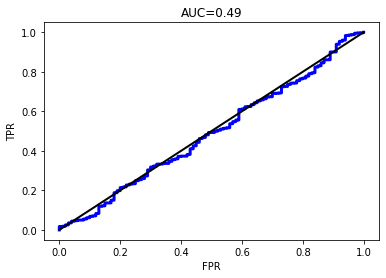

In [ ]:
# Plot ROC-AUC Curve
import matplotlib.pyplot as plt

plt.plot(all_fpr, all_tpr, 'b', lw=3)
plt.plot([0, 1], [0, 1], 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC={}'.format(round(auc_score, 2)))

For exercise A, the no. of positive points (10,000) is far greater than the no. of negative points (100). The predicted points are all positive. Looking at the performance metrics, accuracy and F1 score are high but the AUC score is low.

<h3>B. Compute performance metrics for the given data '5_b.csv'</h3>

In [ ]:
df = pd.read_csv('5_b.csv')
df_b = df.copy() 
df_b.head()

,y,proba
0,0.0,0.281035
1,0.0,0.465152
2,0.0,0.352793
3,0.0,0.157818
4,0.0,0.276648


In [ ]:
print("No. of records with y=0:", df_b[df_b['y']==0].shape[0])
print("No. of records with y=1:", df_b[df_b['y']==1].shape[0])
print("No. of records with proba<0.5:", df_b[df_b['proba']<0.5].shape[0])

No. of records with y=0: 10000
No. of records with y=1: 100
No. of records with proba<0.5: 9806


In [ ]:
df_b['y_pred'] = df_b['proba'].apply(lambda x: 1 if x > 0.5 else 0)
df_b.head()

,y,proba,y_pred
0,0.0,0.281035,0
1,0.0,0.465152,0
2,0.0,0.352793,0
3,0.0,0.157818,0
4,0.0,0.276648,0


In [ ]:
cal_confusion_matrix(df_b['y'], df_b['y_pred'])

array([[9761.,  239.],
       [  45.,   55.]])

In [ ]:
# compare to sklearn confusion matrix
confusion_matrix(df_b['y'], df_b['y_pred'])

array([[9761,  239],
       [  45,   55]])

In [ ]:
print('Custom Accuracy score:', cal_accuracy(df_b['y'], df_b['y_pred']))
print('sklearn Accuracy score:', accuracy_score(df_b['y'], df_b['y_pred'])) # compare to sklearn accuracy

Custom Accuracy score: 0.9718811881188119
sklearn Accuracy score: 0.9718811881188119


In [ ]:
print('Custom F1 score:', cal_f1_score(df_b['y'], df_b['y_pred']))
print('sklearn F1 score:', f1_score(df_b['y'], df_b['y_pred'])) # compare to sklearn f1_score

Custom F1 score: 0.2791878172588833
sklearn F1 score: 0.2791878172588833


In [ ]:
cal_tpr_fpr(df_b['y'], df_b['y_pred']) # TPR = 55% and FPR = 2.39%

[0.55, 0.0239]

In [ ]:
all_tpr, all_fpr = cal_tpr_fpr_threshold(df)
auc_score = np.trapz(all_tpr, all_fpr)

In [ ]:
print('Custom AUC score:', auc_score)
print('sklearn AUC score:', roc_auc_score(df_b['y'], df_b['proba'])) # compare to sklearn roc_auc_score

Custom AUC score: 0.9377570000000001
sklearn AUC score: 0.9377570000000001


Text(0.5, 1.0, 'AUC=0.94')

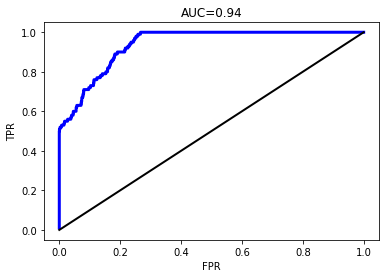

In [ ]:
# Plot ROC-AUC Curve
import matplotlib.pyplot as plt

plt.plot(all_fpr, all_tpr, 'b', lw=3)
plt.plot([0, 1], [0, 1], 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('AUC={}'.format(round(auc_score, 2)))

For exercise B, the no. of negative points (10,000) is far greater than the no. of positive points (100). The predicted points are mostly negative (9806). Looking at the performance metrics, accuracy and AUC score are high but the F1 score is low.

<h3>C. Compute the best threshold (similarly to ROC curve computation) of probability which gives lowest values of metric A for the given data</h3>

In [ ]:
df_c = pd.read_csv('5_c.csv')
df_c.head()

,y,prob
0,0,0.458521
1,0,0.505037
2,0,0.418652
3,0,0.412057
4,0,0.375579


In [ ]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2852 entries, 0 to 2851
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2852 non-null   int64  
 1   prob    2852 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 44.7 KB


In [ ]:
print("No. of records with y=0:", df_c[df_c['y']==0].shape[0])
print("No. of records with y=1:", df_c[df_c['y']==1].shape[0])
print("No. of records with prob<0.5:", df_c[df_c['prob']<0.5].shape[0])

No. of records with y=0: 1805
No. of records with y=1: 1047
No. of records with prob<0.5: 2099


In [ ]:
# define custom function to calculate A metric with param actual (array of actual labels), prob (array of prob scores) and threshold
# https://www.kaggle.com/paulrohan2020/performance-metrics-without-sklearn#AUC-ROC-Score-Calculation

def cal_A_metric(actual, prob, threshold):
    tp = 0
    fp = 0
    tn = 0
    fn = 0

    for i in range(len(prob)):
        if prob[i] >= threshold :
            if actual[i] == 1:
                tp += 1
            else:
                fp += 1

        if prob[i] < threshold:
            if actual[i] == 0:
                tn += 1
            else:
                fn += 1

    A = (500 * fn) + (100 * fp)

    return A

In [ ]:
# define custom function to calculate min of A metric with param actual (array of actual labels), prob (array of prob scores) and threshold
# https://www.kaggle.com/paulrohan2020/performance-metrics-without-sklearn#AUC-ROC-Score-Calculation
def cal_min_a(actual, prob, unique_prob_thresholds):
  min_a = float('inf')
  min_threshold = 0

  for threshold in unique_prob_thresholds:
    a = cal_A_metric(actual, prob, threshold)
    if a <= min_a:
        min_a = min(a, min_a)
        min_threshold = threshold

  return min_a, min_threshold

In [ ]:
probability_thresholds_c = df_c['prob'].unique()
probability_thresholds_c

array([0.45852068, 0.50503693, 0.41865174, ..., 0.29210877, 0.65916054,
       0.45626546])

In [ ]:
min_a, min_t = cal_min_a(df_c['y'], df_c['prob'], probability_thresholds_c)
print('The min value of A is {} with threshold probablity of {}'.format(min_a, min_t))

The min value of A is 141000 with threshold probablity of 0.2300390278970873


<h3>D. Compute performance metrics(for regression) for the given data 5_d.csv</h3>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [ ]:
df_d = pd.read_csv('5_d.csv')
df_d.head()

,y,pred
0,101.0,100.0
1,120.0,100.0
2,131.0,113.0
3,164.0,125.0
4,154.0,152.0


In [ ]:
df_d[df_d['y']==0].shape # there are actual values of 0 (which will affect standard MAPE)

(5717, 2)

In [ ]:
# define custom mean squared error function with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_mse(actual, predicted):
  mse = np.mean((actual - predicted)**2)
  return mse

In [ ]:
print('Custom mean squared error:', cal_mse(df_d['y'], df_d['pred']))
print('sklearn mean squared error:', mean_squared_error(df_d['y'], df_d['pred'])) # compare to sklearn roc_auc_score

Custom mean squared error: 177.16569974554707
sklearn mean squared error: 177.16569974554707


In [ ]:
# define custom mean absolute percentage error function (based on standard formula) - not used
# with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_mape(actual, predicted):
  mape = np.mean(np.abs((actual - predicted)/actual))
  return mape

In [ ]:
# define custom modified mean absolute percentage error function with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_modified_mape(actual, predicted):
  mape = np.mean(np.abs((actual - predicted)/np.mean(actual))) # for denominator, replace actual values with mean of all actual values to account for scenario where actual value=0
  return mape

In [ ]:
# define custom modified mean absolute percentage error function with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_modified_mape2(actual, predicted):
  mape = ((np.sum(np.abs(actual - predicted))) / np.sum(actual)) # use formula in modified MAPE video: https://www.youtube.com/watch?v=ly6ztgIkUxk
  return mape

In [ ]:
print('Custom mean absolute percentage error:', cal_modified_mape(df_d['y'], df_d['pred']))
print('Custom mean absolute percentage error 2:', cal_modified_mape2(df_d['y'], df_d['pred'])) # custom MAPE functions should return similiar values
print('sklearn mean absolute percentage error:', mean_absolute_percentage_error(df_d['y'], df_d['pred'])) # compare to sklearn MAPE (value returned is large as there are actual value = 0)

Custom mean absolute percentage error: 0.12912029940096315
Custom mean absolute percentage error 2: 0.1291202994009687
sklearn mean absolute percentage error: 383407594230912.0


In [ ]:
# define custom r2 score function with param actual (array of actual labels) and predicted (array of predicted labels)
def cal_r2_score(actual, predicted):
  r2_score = 1 - np.sum((actual - predicted)**2) / np.sum((actual - np.mean(actual))**2)
  return r2_score

In [ ]:
print('Custom r2 score:', cal_r2_score(df_d['y'], df_d['pred']))
print('sklearn r2 score:', r2_score(df_d['y'], df_d['pred'])) # compare to sklearn r2

Custom r2 score: 0.9563582786990937
sklearn r2 score: 0.9563582786990937
